# Fitting a model

So far, we have created toy examples of models acting in simulated environment. But how do we use RL mdoels to analyze real, experimental data? in this notebook, we will go through an example analyzing behavioral data from a RL-like task in humans.

In [67]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm
import os
import seaborn as sns
from pybads.bads import BADS
sns.set(style="whitegrid", font="Helvetica")

## The Task

We are going to use real data from a task designed in 2018 by Anne Collins. 

## The Data

The following code is just needed to extra the data from one 6-stimulus blocks from one particular participant, coded as 7501.

In [188]:
data = pd.read_csv("igt_sub_032.txt", index_col=None)
data

,Deck,Immediate,Delayed,Total,Date,Time,RT,Feedback,DualTask
0,A,100,0,2000,27/01/2006,"12:07'35""180",4046,True,False
1,A,120,0,2100,27/01/2006,"12:07'44""023",4807,True,False
2,A,80,-150,2220,27/01/2006,"12:07'49""120",1071,True,False
3,A,90,0,2150,27/01/2006,"12:07'54""738",1572,True,False
4,D,50,0,2240,27/01/2006,"12:08'01""969",3205,True,False
...,...,...,...,...,...,...,...,...,...
95,A,90,0,6205,27/01/2006,"12:15'06""769",3705,True,False
96,A,100,-250,6295,27/01/2006,"12:15'11""707",922,True,False
97,C,40,-50,6145,27/01/2006,"12:15'16""253",501,True,False
98,C,55,0,6135,27/01/2006,"12:15'20""760",471,True,False


As a result, the variable `data` now contains a dataframe (a table) of 100 rows, one for each trial, and 9 columns, which contain the information about each trial (the deck chosen, the immediate and delayed feedback, the response time, and additional metadata)

We can check how the different responses are coded:

In [189]:
set(data.Deck)

{'A', 'B', 'C', 'D'}

We can also check a participant's profile 

In [190]:
data.groupby('Deck').agg('count')

,Immediate,Delayed,Total,Date,Time,RT,Feedback,DualTask
Deck,,,,,,,,
A,14,14,14,14,14,14,14,14
B,14,14,14,14,14,14,14,14
C,12,12,12,12,12,12,12,12
D,60,60,60,60,60,60,60,60


# The model

It is easy to design an RL model for this task. There is only a single _state_, which corresponds to the condition in which a participant makes a decision. The four possible _decks_ correspond to the four _actions_ $A, B, C, D$. The sum of the _immediate_ and _delayed_ feedback corresponds to our reward signal $r_{t+1}$. And, because we have actions, our model will be a model that learn _Q_ values.

Because each trial consists of only one response to a single state (that is, we don’t have multiple states), the _Q_-learning equation reduces to:

$$ Q(s) = Q(s) + \alpha [r_{t+1} - Q(s)] $$

We also need a way to select actions, given the model's _Q_-table. We will use the Boltzmann policy:

$$P(a_i) = \exp(\frac{-Q(a_i)}{T}) / \sum_j \exp(\frac{-Q(a_i)}{T})$$

In [191]:
def boltzmann(options, values, temperature):
    """Returns a Boltzmann distribution of the probabilities of each option"""
    temperature = max(temperature, 0.01) 
    vals = np.array(values)/temperature
    bvals = np.exp(vals - np.max(vals)) / np.exp(vals - np.max(vals)).sum()
    return dict(zip(options, bvals))

## Fitting a Model With Maximum Likelihood

Fitting a model is the process of finding parameter values $\theta$ that reduce the difference between observed data $Y$ and model's predictions $Y’$. In most modern modeling approaches, we tend to use the __maximum likelihood__ approach.

The likelihood of $\theta$ is probability that $\theta$ would produce data that is identical to the observed data $x$:

$$ L(\theta | x) = P(x | \theta) $$

Our goal is to find the values of $\theta$ that maximize $L$!

### Handling Data Vectors

Our data $x$ is a vector of 78 responses, one for each trial:

$$ x = x_1, x_2,\dots, x_{78} $$


The probability that $\theta$ would generate the data vector $x$ is the product of the probabilities of that $\theta$ would generate each response in the sequence:

$$P(x | \theta) = P(x_1 | \theta) \times P(x_2 | \theta) \times \dots \times P(x_{78} | \theta) = \prod_i P(x_i | θ)$$

Because the products of probabilities get vanishingly small, we use _logs_ of probabilities instead---logs of small values become large negative values.

$$\log P(x | \theta) = \log \left( \prod_i P(x_i | \theta) \right) = \sum_i \log P(x_i | \theta)$$

### The Algorithm

Now that we have everything in place, we need a function to compute the log-likelihood of a given set of responses, given some parameters $\theta$. The algorithm is just this:

* Create a $Q$-table, with 4 entries (4 actions, one for each deck). 
* Set all $Q$-values to zero
* Create a variable _L_ to save the log-likelihood value, and set it to zero: $L = 0$
* Then, for each response $x_1, x_2, \dots, x_{100}$:
   * Calculate $P(x)$ using Boltzmann equation
   * Update the log likelihood by adding the log of $P(x)$: $L = L + \log P(x)$
   * And finally, update the value $Q(s, x)$ using _Q_-learning: $Q(s, x) = Q(s, x) + \alpha[r_{t+1} - Q(s, x)]$
* At the end return _L_


In [192]:
Q={}
def LL(data, alpha, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    global Q
    LL = 0.0
    Q = {}
    
    # Set Q-values to zero
    
    for action in set(data.Deck):
        Q[action] = 0.0
    
    # Loop over all trials
    
    for i, action in enumerate(data.Deck):
        reward = data.Immediate.iloc[i] + data.Delayed.iloc[i]
        # Calculate log likelihood of each specific response
        
        options = [x for x in Q.keys()] 
        values = [Q[opt] for opt in options]
        prob = boltzmann(options, values, temp)[action]
        
        # Sum up the LLs of each choice
        
        LL += np.log(max(prob, 10e-10))
        
        # Updates the Q values using Q-learning
        
        Q_old = Q[action]
        Q[action] = Q_old + alpha * (reward - Q_old)
        
    return LL


Example: What is the log-likelihood of $\alpha = 0.1, T = 2.0$?

In [225]:
LL(data, 0.005, 11)

-122.58218951235254

# Grid search

We can calculate the log-likelihoods for different combinations of $0.05 < \alpha < 0.55$ and $0 < T < 10$ 

In [194]:
alphaspace = np.arange(0.1, 1.01, 0.1)
tempspace = np.arange(1, 10.05, 1)
matrix = np.zeros((len(alphaspace), len(tempspace)))
for i, a in enumerate(alphaspace):
    for j, t in enumerate(tempspace):
        matrix[i,j] = LL(data, a, t)

And we can visualize them

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_3043/2559159405.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in alphaspace])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_3043/2559159405.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 2)) for x in tempspace])


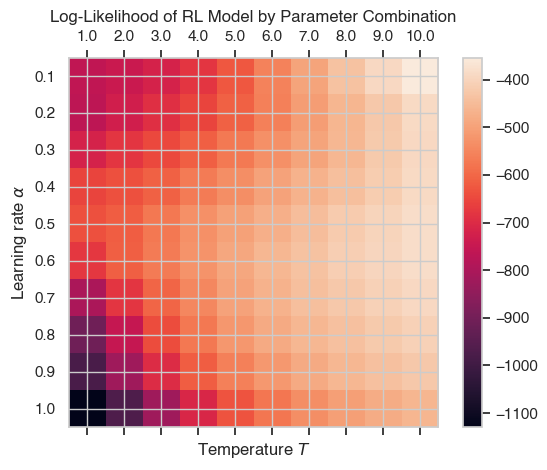

In [195]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation='nearest')
fig.colorbar(cax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_yticklabels([''] + [str(round(x, 2)) for x in alphaspace])
ax.set_xticklabels([''] + [str(round(x, 2)) for x in tempspace])
ax.set_ylabel(r"Learning rate $\alpha$ ")
ax.set_xlabel(r"Temperature $T$ ")
ax.set_title("Log-Likelihood of RL Model by Parameter Combination")
plt.show()

## Optimization

Grod-search is rarely used. Instead, in moderl mdoel-fitting, we use optimization techniques. Most algorithms are already available as software packages; in Python, they are available in SciPy's `minimize` package. These algorithms use __minimization__ techniques, minimizing a loss function that takes as an argument an array of parameters $\theta$ and return a loss value. Because we want to _maximize_ log-likelihood, we will define our loss function as the inverse of the log-likelihood. 

In [196]:
intermediate = [] # Saves intermediate results for visualization

def loss(theta):
    """Loss function = 1 * log-likelihood"""
    global data
    alpha, temp = theta
    intermediate.append(theta)
    return -1 * LL(data, alpha, temp)

Here is an example, in wjhich we will minimize the loss using the Nelder-Mead "simplex" algorithm

In [197]:
intermediate = []
opt.minimize(loss, x0 = [0.25, 5], method = "Powell", bounds=[[0.1,1],[1,10]])

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 379.73040537390517
       x: [ 5.486e-01  1.000e+01]
     nit: 3
   direc: [[-1.617e-05 -2.430e-04]
           [-4.921e-06  7.680e-09]]
    nfev: 224

The `intermediate` list contains all the points in parameter space examined by the minimization function.

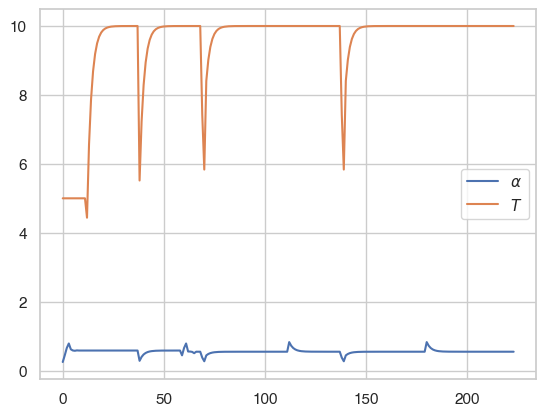

In [198]:
plt.plot(intermediate, label=[r"$\alpha$", "$T$"])
plt.legend()
plt.show()

And here are the results of the minimization search, overlaid over the parameter space matrix

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_3043/1545915183.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + [str(round(x, 2)) for x in alphaspace])
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_3043/1545915183.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + [str(round(x, 2)) for x in tempspace])


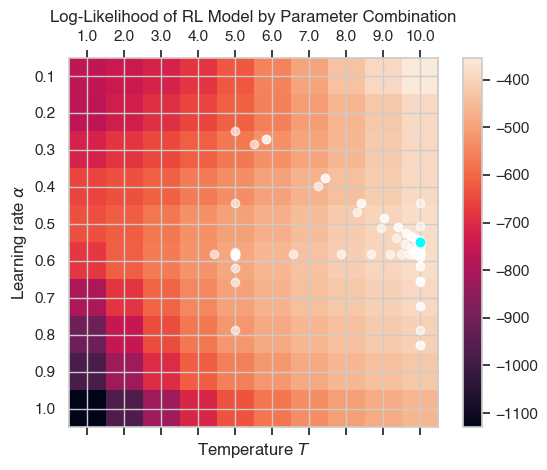

In [199]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation='nearest')
fig.colorbar(cax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_yticklabels([''] + [str(round(x, 2)) for x in alphaspace])
ax.set_xticklabels([''] + [str(round(x, 2)) for x in tempspace])
ax.set_ylabel(r"Learning rate $\alpha$ ")
ax.set_xlabel(r"Temperature $T$ ")
ax.set_title("Log-Likelihood of RL Model by Parameter Combination")

for y, x in intermediate[:-1]:
    plt.plot(x-1, (y-0.1)*10, "o", color="white", alpha=0.6)

y, x = intermediate[-1]
plt.plot(x-1, (y-0.1)*10, "o", color="cyan")

plt.show()

Better than chance? We can compute the likelihood of perfect random responses: it is just given by:

$$LL_{random} = N \times \log(1/4) $$

In [228]:
100*np.log(1/4)

-138.62943611198907